# Controller behavior

I want to see how the controller is behaving, particularly
1. Is the error staying below the target?
2. How are the controller parameters, uncertainty, and error varying with time
3. How well is the UQ correlated with the error

Right now I am looking at one of our NVT trajectories. 

The answers are 
1. Yes, but there are some very large outliers **I think the outliers could be from the max over forces...**
2. The threshold varies a lot faster than the UQ, which worries me. I think this is driven by the large errors making the update large
3. The correlation is extremely weak

In [1]:
from pathlib import Path
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import scipy as sp
from scipy import stats

In [2]:
run_dir = Path('./runs/si-vacancy-2x2x2-temp=1573.0-method=lda-blend=0-2bcd06d4/')

In [3]:
data = pd.read_json(run_dir/'proxima-log.json', lines=True)

In [4]:
with open(run_dir/'params.json') as f: 
    params = json.load(f)
params

{'file': None,
 'starting_strc': '../0_setup/initial-geometries/si-vacancy-2x2x2.vasp',
 'temperature': 1573.0,
 'timestep': 1,
 'calculator': 'lda',
 'ensemble': 'nvt',
 'temp_tau': 25,
 'stress_tau': 25.0,
 'steps': 40000,
 'seed': 1,
 'bulk_modulus': 98.0,
 'initial_volume': 1376.0,
 'model_type': 'ani',
 'initial_model': None,
 'initial_data': [],
 'ensemble_size': 2,
 'online_training': True,
 'training_epochs': 16,
 'training_batch_size': 32,
 'training_max_size': 512,
 'training_recency_bias': 1.0,
 'training_device': 'cpu',
 'target_error': 0.9,
 'error_history': 8,
 'retrain_freq': 512,
 'min_target_frac': 0.1,
 'n_blending_steps': 0,
 'cascade_commit': '5fda70cf55730fb117bf65924cfd5fae9fd3b0ed',
 'my_commit': '5fda70cf55730fb117bf65924cfd5fae9fd3b0ed',
 'start_time': '2024-10-02T15:29:03.963278'}

# How often are we using the surrogate?

In [5]:
t = np.arange(data.shape[0]) # need for scatter plots

In [6]:
data['used_surrogate'].mean()

0.5611822725316916

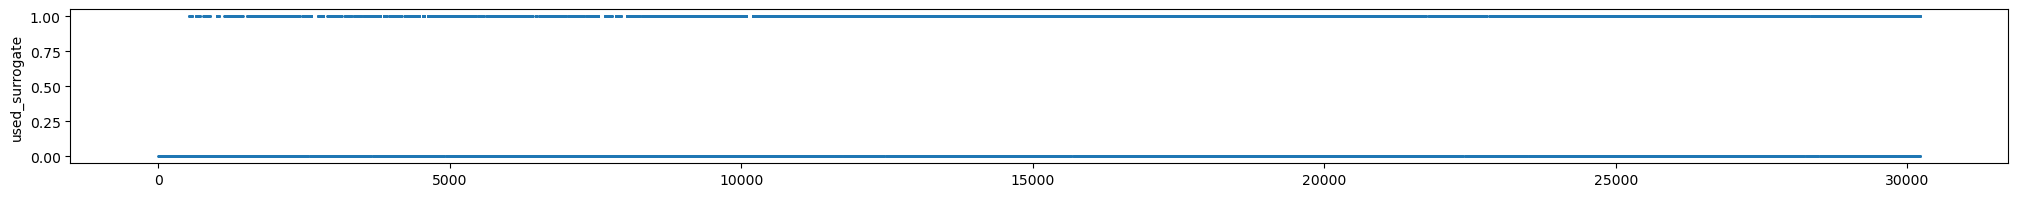

In [7]:
fig, ax = plt.subplots(figsize=(25, 2))
plt.scatter(t, data['used_surrogate'], s=1)
plt.ylabel('used_surrogate')
plt.show()

It looks like we are switching it on and off pretty rapidly for most of the simulation. 

# Error vs target

I just want to see if we are staying below the target

In [8]:
target_error = params['target_error']

### Filter out the steps where we used the target
I don't want to overcount errors when the surrogate is used for multiple steps in a row

In [9]:
target_idx = data['used_surrogate'] == False

In [10]:
target_steps = data.query('used_surrogate == False')

In [11]:
t_target = t[target_idx]

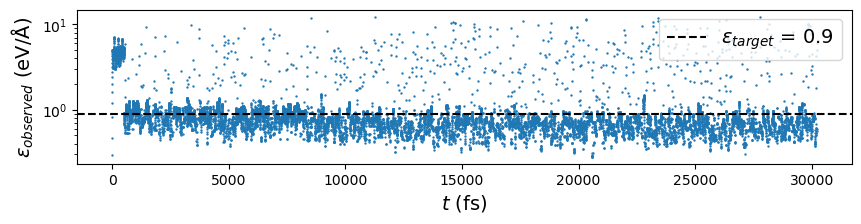

In [12]:
start_ix = 0
fig, ax = plt.subplots(figsize=(10, 2))
plt.scatter(t_target[start_ix:], target_steps['last_error'][start_ix:], s=0.5)
plt.axhline(0.9, color='k', linestyle='dashed', label='$\epsilon_{target}$ = 0.9')
plt.yscale('log')
plt.ylabel('$\epsilon_{observed}$ (eV/$\mathrm{\AA}$)', fontsize=14)
plt.xlabel('$t$ (fs)', fontsize=14)
plt.legend(fontsize=14)
plt.savefig('controller.png', bbox_inches='tight', dpi=500)
plt.show()

It looks like we are staying below the threshold most of the time, but there are some pretty large outliers.  
On average we are a little above the error, but once you remove the burnin period we are below the average

In [13]:
target_steps['last_error'].mean()

1.0368467315084777

In [14]:
start_ix = 512
filtered = target_steps['last_error'][start_ix:]
filtered.mean()

0.8963870173543562

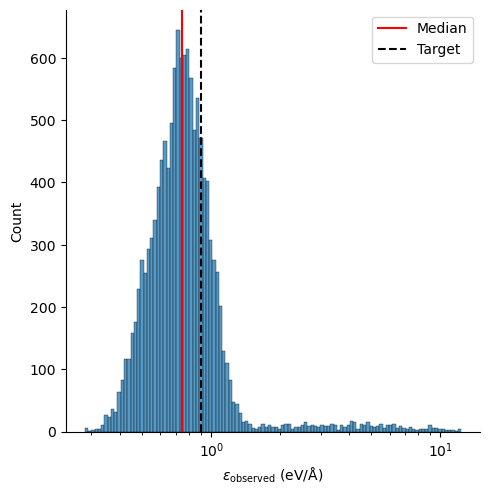

In [15]:
g = sns.displot(filtered, log_scale=True)
g.ax.axvline(filtered.median(), color='red', label='Median')
g.ax.axvline(target_error, color='k', linestyle ='dashed', label='Target')
plt.xlabel('$\epsilon_\mathrm{observed}$ (eV/$\mathrm{\AA}$)')
plt.legend()
plt.show()


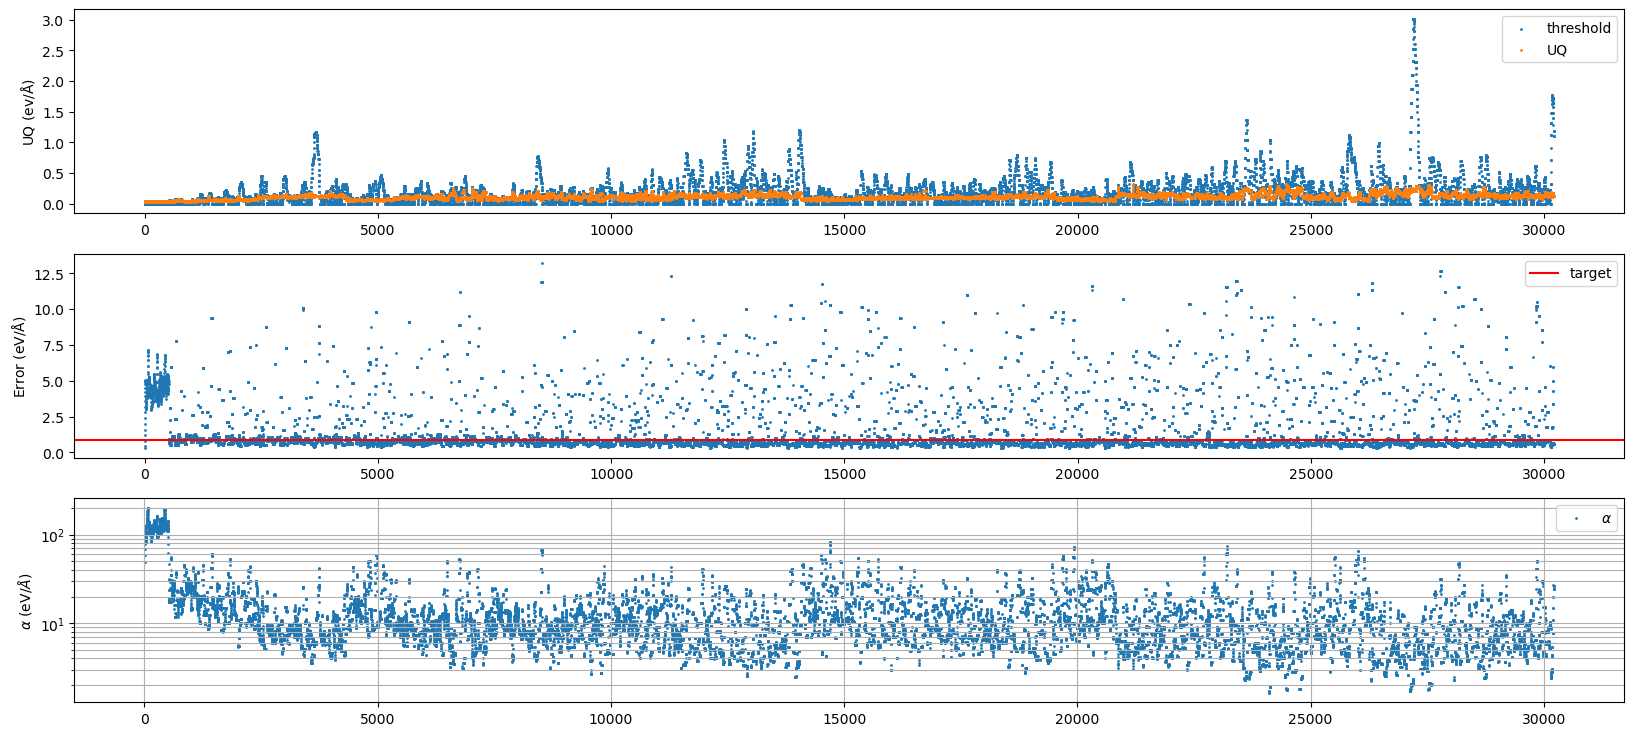

In [16]:
fig, ax = plt.subplots(3, figsize=(20, 9))
plt.sca(ax[0])
plt.scatter(t, data['proxima_threshold'], s=1, label='threshold')
plt.scatter(t, data['last_uncer'], s=1, label='UQ')
plt.ylabel('UQ (ev/$\mathrm{\AA}$)')
plt.legend()

plt.sca(ax[1])
plt.scatter(t, data['last_error'], s=1)
plt.ylabel('Error (eV/$\mathrm{\AA}$)')
plt.axhline(target_error, color='red', label='target')
plt.legend()

plt.sca(ax[2])
plt.scatter(t, data['proxima_alpha'], s=1, label=r'$\alpha$')
plt.ylabel(r'$\alpha$ (eV/$\AA$)')
plt.legend()
plt.yscale('log')
plt.grid(True, which='both')
plt.show()

I don't like that tere is a lot more variability in the threshold than in the UQ.  
I think thats probably related to the very large outlier errors. And perhaps our lack of integral control?   
But it seems like the UQ isnt influencing our decisions that much, sicne the threshold is moving around much more.

## UQ vs error

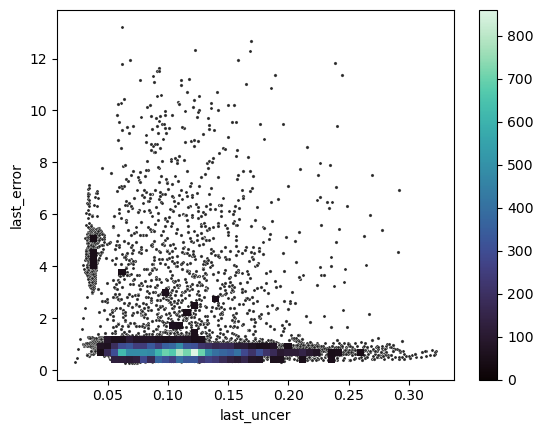

In [17]:
sns.scatterplot(x=data['last_uncer'], y=data['last_error'], s=5, color=".15")
sns.histplot(x=data['last_uncer'], y=data['last_error'], bins=50, pthresh=0.22, cmap="mako", cbar=True)
plt.show()

In [18]:
sp.stats.spearmanr(data['last_uncer'], data['last_error'])

SignificanceResult(statistic=-0.12576099897992432, pvalue=9.475760649267092e-107)

Its actually pretty crazy how well this works considering how poorly correlated the UQ is with error. 

## Sanity checking the alpha fitting

The way it is in the present implementation:

In [19]:
many_alphas = np.true_divide(target_steps['last_error'], np.clip(target_steps['last_uncer'], 1e-6, a_max=np.inf))  # Alpha's units: error / UQ
alpha = np.mean(many_alphas)
alpha

13.64039424331319

In [20]:
from sklearn.linear_model import LinearRegression

The way its done here https://github.com/globus-labs/sluschi-proxima/blob/57b6ee0e960facc228066bd863ebf10c330b51b0/mddemo/decorator.py#L168 

In [21]:
lr = LinearRegression(fit_intercept=False)

In [22]:
lr.fit(X=target_steps['last_error'].array[:, np.newaxis], y=target_steps['last_uncer'])
lr.coef_

array([0.04394179])

In [23]:
lr.fit(X=target_steps['last_uncer'].array[:, np.newaxis], y=target_steps['last_error'])
lr.coef_

array([7.02656649])